# Prepare train/test datasets

In [1]:
import pandas as pd
import os.path
import os
import h5py
import numpy as np
import tqdm
import itertools
import matplotlib.pyplot as plt


In [147]:
AFGRUNDIR = "/media/vsevolod/T7/work/prj_kn_afterglow/"
sim = {}; sim["name"] = "SFHoTim276_13_14_0025_150mstg_B0_HLLC"
collated_file_path = AFGRUNDIR + sim["name"] + '/' + "collated.csv"

assert os.path.isfile(collated_file_path), "Collated file not found"
df = pd.read_csv(collated_file_path, index_col=0)
print(f"File loaded: {collated_file_path} {print(df.info(memory_usage='deep'))}")

AssertionError: Collated file not found

In [148]:
target = "flux"

In [4]:
def _visualize_df(df:pd.DataFrame, name:str):
    print(f"\t> Visualizing {name} Shape: {df.shape}")

    display(df.head(2))

    print(f"\t Duplicated_rows: {df.duplicated().sum()}")

    # check df properties
    def analyze_df(df : pd.DataFrame)->pd.DataFrame:
        res = pd.DataFrame({
            "is_unique": df.nunique() == len(df),
            "unique": df.nunique(),
            "with_nan":df.isna().any(),
            "percent_nan":round((df.isnull().sum()/len(df))*100,4),
            "min":df.min(),
            "max":df.max(),
            "mean":df.mean(),
            "dtype":df.dtypes
        })
        return res
    print(f"\t> Numeric features: {df.select_dtypes(exclude='object').shape[1]} \n"
          f"{df.select_dtypes(exclude='object').keys()}")
    print(f"\t> Object features: {df.select_dtypes(exclude='number').shape[1]} \n"
          f"{df.select_dtypes(exclude='number').keys()}")
    print(f"\t Analyzing {name} Summary:")
    metadata = analyze_df(df=df)
    return metadata
metadata = _visualize_df(df=df, name=sim["name"])
display(metadata)

	> Visualizing SFHoTim276_13_14_0025_150mstg_B0_HLLC Shape: (6480000, 9)


,eps_e,eps_b,eps_t,p,theta_obs,n_ism,freq,time,flux
0,0.001,0.001,0.01,2.2,0.0,0.001,2.400000e+09,100000.000000,7.278929e-11
1,0.001,0.001,0.01,2.2,0.0,0.001,2.400000e+09,106332.657164,8.460537e-11


	 Duplicated_rows: 0
	> Numeric features: 9 
Index(['eps_e', 'eps_b', 'eps_t', 'p', 'theta_obs', 'n_ism', 'freq', 'time',
       'flux'],
      dtype='object')
	> Object features: 0 
Index([], dtype='object')
	 Analyzing SFHoTim276_13_14_0025_150mstg_B0_HLLC Summary:


,is_unique,unique,with_nan,percent_nan,min,max,mean,dtype
eps_e,False,5,False,0.0,1.000000e-03,5.000000e-01,1.322000e-01,float64
eps_b,False,5,False,0.0,1.000000e-03,5.000000e-01,1.322000e-01,float64
eps_t,False,4,False,0.0,1.000000e-02,1.000000e+00,4.025000e-01,float64
p,False,4,False,0.0,2.200000e+00,2.800000e+00,2.500000e+00,float64
theta_obs,False,3,False,0.0,0.000000e+00,1.570796e+00,7.853982e-01,float64
n_ism,False,6,False,0.0,1.000000e-03,1.000000e+00,2.768333e-01,float64
freq,False,6,False,0.0,2.400000e+09,9.300000e+10,3.123333e+10,float64
time,False,150,False,0.0,1.000000e+05,9.404449e+08,1.052639e+08,float64
flux,True,6480000,False,0.0,4.115669e-13,1.015367e+02,1.489473e-01,float64


# Select and tansform features

In [5]:
# Set target
metadata["target"] = "flux"

In [6]:
# Print total number of lightcurves
n_curves = np.prod([metadata["unique"][key] for key in df.columns if key not in ["flux","time"]])
n_times = metadata["unique"]["time"]
print(f"total number of light curves: {n_curves} times: {n_times}")

total number of light curves: 43200 times: 150


In [7]:
unique_times = np.array([10, 20, 30])
physical_parameters = np.array([1,2,3,4,5])
all_data_input = np.hstack((
    np.repeat(physical_parameters.reshape(1, -1), len(unique_times), axis=0),
    unique_times.reshape(-1, 1)
))
print(all_data_input.shape)
print(all_data_input)

(3, 6)
[[ 1  2  3  4  5 10]
 [ 1  2  3  4  5 20]
 [ 1  2  3  4  5 30]]


# Create Numpy Arrays from Dataframe

In [62]:
# Prepare data in numpy arrays
features_names = [col for col in list(df.columns) if col not in [target, "time"]]
print(f"Target name: '{target}' features_names: {features_names}")

def LcCollatedDataFrameToNumpyArray(df:pd.DataFrame, metadata:pd.DataFrame,target="flux",time="time"):

    n_curves = np.prod([metadata["unique"][key] for key in features_names])#df.columns if key not in ["flux","time"]])
    n_times = metadata["unique"]["time"]
    print(f"Total number of light curves: {n_curves} times: {n_times}")

    grouped = df.groupby(features_names)
    pars = np.vstack([np.array(key) for key, val in grouped.groups.items()])
    lcs  = np.vstack([np.array(df[target].iloc[val]) for key, val in grouped.groups.items()])
    times= np.array(np.array(df[time].unique()))
    assert len(times) == len(lcs[0])
    assert n_curves == len(lcs)
    return (lcs, pars, times)

lcs, pars, times = LcCollatedDataFrameToNumpyArray(df, metadata)  

print(f"lcs={lcs.shape}, pars={pars.shape}, times={times.shape}")

with h5py.File(os.getcwd()+'/data/'+"X.h5","w") as f:
    f.create_dataset("X", data=lcs, dtype=np.float32)
    f.create_dataset("time", data=times, dtype=np.float64)

with h5py.File(os.getcwd()+'/data/'+"Y.h5","w") as f:
    f.create_dataset("Y", data=pars, dtype=np.float32)
    f.create_dataset("keys", data=np.array(features_names,dtype="S"))
print("Data saved as .h5 files")

Target name: 'flux' features_names: ['eps_e', 'eps_b', 'eps_t', 'p', 'theta_obs', 'n_ism', 'freq']
Total number of light curves: 43200 times: 150
lcs=(43200, 150), pars=(43200, 7), times=(150,)
Data saved as .h5 files


In [2]:
# Read data from local
with h5py.File(os.getcwd()+'/data/'+"X.h5","r") as f:
    lcs = np.array(f["X"])
    times = np.array(f["time"])

with h5py.File(os.getcwd()+'/data/'+"Y.h5","r") as f:
    pars = np.array(f["Y"])
    features_names = list(f["keys"])

print(f"lcs={lcs.shape}, pars={pars.shape}, times={times.shape}")
print(f"lcs={lcs.min()}, {lcs.max()}, pars={pars.min()} {pars.max()}, times={times.shape}")

lcs=(43200, 150), pars=(43200, 7), times=(150,)
lcs=4.1156688517299256e-13, 101.53666687011719, pars=0.0 92999999488.0, times=(150,)


In [3]:
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn import preprocessing

# Create DataLoader class for Neural Network

In [4]:
class LightCurveDataset(Dataset):
    """
    LightCurve dataset
    Dispatches a lightcurve to the appropriate index
    """
    def __init__(self, pars:np.ndarray, lcs:np.ndarray, times:np.ndarray, device="gpu"):
        self.device = device
        self.pars = np.array(pars)
        self.lcs = np.array(lcs)
        assert self.pars.shape[0] == self.lcs.shape[0], "size mismatch between lcs and pars"
        self.times = times
        self.len = len(self.lcs)
        
        # preprocess parameters
        self.scaler = preprocessing.MinMaxScaler()
        self.scaler.fit(pars)
        self.pars_normed = self._transform_pars(pars)
        # inverse transform
        # inverse = scaler.inverse_transform(normalized)
        if np.min(self.pars_normed) < 0 or np.max(self.pars_normed) > 1:
            raise ValueError("Parameter normalization error")
        # preprocess lcs 
        self._transform_lcs(self.lcs)
        if np.min(self.lcs_log_norm) < 0 or np.max(self.lcs_log_norm) > 1:
            raise ValueError("Parameter normalization error")

    def __getitem__(self, index):
        """ returns image/lc, vars(params)[normalized], vars(params)[physical] """
        return (torch.from_numpy(self.lcs_log_norm[index]).to(self.device).to(torch.float),
                torch.from_numpy(self.pars_normed[index]).to(self.device).to(torch.float),  # .reshape(-1,1)
                self.lcs[index], 
                self.pars[index])
    
    def __len__(self):
        return len(self.lcs)
    
    def _transform_lcs(self, lcs):
        log_lcs = np.log10(lcs)
        self.lc_min = log_lcs.min()
        self.lc_max = log_lcs.max()
        self.lcs_log_norm = (log_lcs - np.min(log_lcs)) / (np.max(log_lcs) - np.min(log_lcs))
    
    def _transform_pars(self, pars):
        return self.scaler.transform(pars)
    
    def inverse_transform_lc_log(self, lcs_log_normed):
        return np.power(10, lcs_log_normed * (self.lc_max - self.lc_min) + self.lc_min)
    
    def get_dataloader(self, batch_size=32, test_split=0.2):
        """
        If 
        :param batch_size: if 1 it is stochastic gradient descent, else mini-batch gradient descent
        :param test_split: 
        :return: 
        """
        dataset_size = len(self)
        indices = list(range(dataset_size))
        split = int(np.floor(test_split * dataset_size))
        np.random.shuffle(indices)
        train_indices, test_indices = indices[split:], indices[:split]

        # Creating PT data samplers and loaders:
        train_sampler = SubsetRandomSampler(train_indices)
        test_sampler = SubsetRandomSampler(test_indices)

        train_loader = DataLoader(self, batch_size=batch_size,
                                  sampler=train_sampler, drop_last=False)
        test_loader = DataLoader(self, batch_size=batch_size,
                                 sampler=test_sampler, drop_last=False)
        
        return (train_loader, test_loader)
    
dataset = LightCurveDataset(pars, lcs, times)

# Create Neural Network 

### Primary Sources:  
- [Paper by Lukosiute](https://arxiv.org/pdf/2204.00285.pdf) with [GitHub code](https://github.com/klukosiute/kilonovanet) using [Bulla's data](https://github.com/mbulla/kilonova_models/tree/master/bns/bns_grids/bns_m3_3comp). 
- [PELS-VAE](https://github.com/jorgemarpa/PELS-VAE) github that had was used to draft train part for Lukosiute net ([data for it](https://zenodo.org/records/3820679#.XsW12RMzaRc))

### Secondary Sources
- [Tronto Autoencoder](https://www.cs.toronto.edu/~lczhang/aps360_20191/lec/w05/autoencoder.html) (Convolutional net)
- [Video with derivations](https://www.youtube.com/watch?v=iwEzwTTalbg)
- [Data sampling with scikit](https://machinelearningmastery.com/how-to-improve-neural-network-stability-and-modeling-performance-with-data-scaling/)
- [Astro ML BOOK repo with code](https://github.com/astroML/astroML_figures/blob/742df9181f73e5c903ea0fd0894ad6af83099c96/book_figures/chapter9/fig_sdss_vae.py#L45)

In [5]:
import torch
import torch.nn as nn

class CVAE(nn.Module):
    """
        Base pytorch cVAE class
    """

    def __init__(self, image_size=150, hidden_dim=50, z_dim=10, c=7):
        """
        :param image_size: Size of 1D "images" of data set i.e. spectrum size
        :param hidden_dim: Dimension of hidden layer
        :param z_dim: Dimension of latent space (latent_units)
        :param c: Dimension of conditioning variables
        """
        super(CVAE, self).__init__()
        self.z_dim = z_dim
        self.c = c
        self.encoder = Encoder(image_size, hidden_dim, z_dim, c) # self.encoder = Encoder(latent_dims)
        self.decoder = Decoder(image_size, hidden_dim, z_dim, c) # self.decoder = Decoder(latent_dims)
        self.init_weights()
        
    def forward(self, y, x):
        """
        Compute one single pass through decoder and encoder

        :param x: Conditioning variables corresponding to images/spectra
        :param y: Images/spectra
        :return: Mean returned by decoder, mean returned by encoder, log variance returned by encoder
        """

        # print("1 x={} y={}".format(x.shape, y.shape))
        y = torch.cat((y, x), dim=1)
        mean, logvar = self.encoder(y)
        # print(f"2 y={y.shape}")
        # re-parametrize
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        sample = mean + eps * std
        # print(f"3 sample={sample.shape}")
        z = torch.cat((sample, x), dim=1)
        # print(f"4 cat(sample,x) -> z={z.shape}")
        mean_dec = self.decoder(z)
        # print(f"5 mean_dec={mean_dec.shape}")
        return (mean_dec, mean, logvar, z)

    def init_weights(self):
        """
            Initialize weight of recurrent layers
        """
        for name, param in self.encoder.named_parameters():
            if 'bias' in name:
                nn.init.normal_(param, 0.0)
            elif 'weight' in name:
                nn.init.xavier_normal_(param)
        for name, param in self.decoder.named_parameters():
            if 'bias' in name:
                nn.init.normal_(param, 0.0)
            elif 'weight' in name:
                nn.init.xavier_normal_(param)


class Encoder(nn.Module):
    """
    Encoder of the cVAE
    """

    def __init__(self, image_size=150, hidden_dim=50, z_dim=10, c=7):
        """
        :param image_size: Size of 1D "images" of data set i.e. spectrum size
        :param hidden_dim: Dimension of hidden layer
        :param z_dim: Dimension of latent space
        :param c: Dimension of conditioning variables

        """
        super().__init__()

        # nn.Linear(latent_dims, 512)
        self.layers_mu = nn.Sequential(
            nn.Linear(image_size + c, hidden_dim), 
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, z_dim),
        )

        self.layers_logvar = nn.Sequential(
            nn.Linear(image_size + c, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, z_dim),
        )

    def forward(self, x):
        """
        Compute single pass through the encoder

        :param x: Concatenated images and corresponding conditioning variables
        :return: Mean and log variance of the encoder's distribution
        """
        mean = self.layers_mu(x)
        logvar = self.layers_logvar(x)
        return mean, logvar


class Decoder(nn.Module):
    """
    Decoder of cVAE
    """

    def __init__(self, image_size=150, hidden_dim=50, z_dim=10, c=7):
        super().__init__()

        self.layers = nn.Sequential(
            nn.Linear(z_dim + c, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, image_size),
            nn.Sigmoid(),
        )

    def forward(self, z):
        """
        Compute single pass through the decoder

        :param z: Concatenated sample of hidden variables and the originally inputted conditioning variables
        :return: Mean of decoder's distirbution
        """
        mean = self.layers(z)
        return mean



model = CVAE(image_size=len(lcs[0]),  #  150
             hidden_dim=700, 
             z_dim=len(pars[0])*4, 
             c=len(pars[0])) # TODO -------------------  check! 
print('Summary:')

n_train_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Num of trainable params: ', n_train_params)
print(model)    

Summary:
Num of trainable params:  1862906
CVAE(
  (encoder): Encoder(
    (layers_mu): Sequential(
      (0): Linear(in_features=157, out_features=700, bias=True)
      (1): Tanh()
      (2): Linear(in_features=700, out_features=700, bias=True)
      (3): Tanh()
      (4): Linear(in_features=700, out_features=28, bias=True)
    )
    (layers_logvar): Sequential(
      (0): Linear(in_features=157, out_features=700, bias=True)
      (1): Tanh()
      (2): Linear(in_features=700, out_features=700, bias=True)
      (3): Tanh()
      (4): Linear(in_features=700, out_features=28, bias=True)
    )
  )
  (decoder): Decoder(
    (layers): Sequential(
      (0): Linear(in_features=35, out_features=700, bias=True)
      (1): Tanh()
      (2): Linear(in_features=700, out_features=700, bias=True)
      (3): Tanh()
      (4): Linear(in_features=700, out_features=150, bias=True)
      (5): Sigmoid()
    )
  )
)


In [6]:
import torch.optim as optim

# Initialize optimizers
# lgorithms that adjust the model's parameters during training to minimize a loss function
optimizer = optim.Adam(model.parameters(), lr=1.e-6) # TODO ------------ CHECK

# Initialize learning Rate scheduler
def select_scheduler(lr_sch='step')->optim.lr_scheduler or None:
    if lr_sch == 'step':
        scheduler = optim.lr_scheduler.StepLR(optimizer,
                                              step_size=10,
                                              gamma=0.1)
    elif lr_sch == 'exp':
        scheduler = optim.lr_scheduler.ExponentialLR(optimizer,
                                                     gamma=0.985)
    elif lr_sch == 'cos':
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer,
                                                         T_max=50,
                                                         eta_min=1e-5)
    elif lr_sch == 'plateau':
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                         mode='min',
                                                         factor=.5,
                                                         verbose=True)
    else:
        scheduler = None
    return scheduler
scheduler = select_scheduler()

print('Optimizer    :', optimizer)
print('LR Scheduler :', scheduler.__class__.__name__)

Optimizer    : Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    initial_lr: 1e-06
    lr: 1e-06
    maximize: False
    weight_decay: 0
)
LR Scheduler : StepLR


In [9]:
from torch.nn import functional as F
import torch.nn as nn
import datetime

import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
if device.type == 'cuda':
    torch.cuda.empty_cache()

class EarlyStopping:
    """Early stops the training if validation loss doesn't
    improve after a given patience."""
    def __init__(self, patience=7, min_delta=0, verbose=False):
        """
        Attributes
        ----------
        patience  : int
            How long to wait after last time validation loss improved.
            Default: 7
        min_delta : float
            Minimum change in monitored value to qualify as 
            improvement. This number should be positive.
            Default: 0
        verbose   : bool
            If True, prints a message for each validation loss improvement.
            Default: False
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.min_delta = min_delta

    def __call__(self, val_loss):

        current_loss = val_loss

        if self.best_score is None:
            self.best_score = current_loss
        elif torch.abs(current_loss - self.best_score) < self.min_delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} / {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = current_loss
            self.counter = 0

def save_checkpoint(model, optimizer, save_path, epoch):
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': epoch
    }, save_path)
        
class Trainer:
    def __init__(self, model:CVAE, optimizer, batch_size, scheduler=None, 
                 beta='step', print_every=50, device='cpu'):
        self.device = device
        self.model = model
        if torch.cuda.device_count() > 1 and True:
            print("Let's use", torch.cuda.device_count(), "GPUs!")
            self.model = nn.DataParallel(self.model)
        self.model.to(self.device)
        print('Is model in cuda? ', next(self.model.parameters()).is_cuda)
        self.opt = optimizer
        self.sch = scheduler
        self.batch_size = batch_size
        self.train_loss = {'KL_latent': [], 'BCE': [], 'Loss': [],
                           'MSE': [], 'KL_output': [], 'tMSE': [],
                           'wMSE': []}
        self.test_loss = {'KL_latent': [], 'BCE': [], 'Loss': [],
                          'MSE': [], 'KL_output': [], 'tMSE': [],
                          'wMSE': []}
        self.num_steps = 0
        self.print_every = print_every
        self.beta = beta
        
        # --- 
        self.model_dir = os.getcwd() + '/models/'
        self.run_name = "test"
    
    def train(self, train_loader, test_loader, epochs, save=True, save_chkpt=True, early_stop=False):
        # hold samples, real and generated, for initial plotting
        if early_stop:
            early_stopping = EarlyStopping(patience=10, min_delta=.01, verbose=True)

        # train for n number of epochs
        time_start = datetime.datetime.now()
        train_losses = []
        val_losses = []
        for epoch in range(1, epochs + 1):
            e_time = datetime.datetime.now()
            print('##'*20)
            print("\nEpoch {}".format(epoch))
            # train and validate
            train_running_loss = self._train_epoch(train_loader, epoch)
            train_running_loss /= len(train_loader)
            train_losses.append(train_running_loss)
            
            # test and get the final loss
            val_loss, val_running_loss = self._test_epoch(test_loader, epoch)
            val_running_loss /= len(test_loader)
            val_losses.append(val_running_loss)
            
            # update learning rate according to scheduler
            if self.sch is not None:
                if 'ReduceLROnPlateau' == self.sch.__class__.__name__:
                    self.sch.step(val_loss)
                else:
                    self.sch.step(epoch)

            # report elapsed time per epoch and total run time
            epoch_time = datetime.datetime.now() - e_time
            elap_time = datetime.datetime.now() - time_start
            
            print(f"\tTime per epoch {epoch_time.seconds} s, Beta={self._beta_scheduler(epoch):.2f}")
            print(f"\tTrain loss {train_running_loss} Validation loss {val_running_loss}")
            print(f"\tElapsed time {elap_time.seconds/60:.2f} m")
            print('##'*20)

            if save_chkpt:
                print("Saving checkpoint...")
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': self.model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'train_loss': train_running_loss,
                    'val_loss': val_running_loss,
                    'beta':self._beta_scheduler(epoch)
                },
                    '%s/VAE_model_%s_%d.chkpt' % (self.model_dir, self.run_name, epoch))

            # early stopping
            if early_stop:
                early_stopping(val_loss.cpu())
                if early_stopping.early_stop:
                    print("Early stopping")
                    break
                

        if save:
            print("Saving model...")
            
            torch.save({
                    "model_state_dict":self.model.state_dict(),
                    "optimizer_state_dict":optimizer.state_dict(),
                },
                '%s/VAE_model_%s.pt' % (self.model_dir, self.run_name))
        
        return (train_losses, val_losses)
        
    def _test_epoch(self, test_loader, epoch):
        """Testing loop for a given epoch. Triningo goes over
        batches, light curves and latent space plots are logged to
        W&B logger

        Parameters
        ----------
        data_loader : pytorch object
            data loader object with training items
        epoch       : int
            epoch number

        Returns
        -------

        """
        
        # set model in an 'eval' mode
        self.model.eval()
        running_loss = 0
        with torch.no_grad():
            xhat_plot, x_plot, l_plot = [], [], []
            for i, (data, label, onehot, pp) in enumerate(test_loader):
                # move data to device where model is
                data = data.to(self.device)
                label = label.to(self.device)
                # evaluate model on the data
                xhat, mu, logvar, z = self.model(data, label)
                # compute loss 
                loss = self._loss(data, xhat, mu, logvar, train=False, ep=epoch)
                # save batch loss
                running_loss += loss.item() * data.size(0)
        
        self._report_test(epoch)

        return (loss, running_loss)

    def _train_epoch(self, data_loader, epoch):
        """Training loop for a given epoch. Triningo goes over
        batches, light curves and latent space plots are logged to
        W&B logger

        Parameters
        ----------
        data_loader : pytorch object
            data loader object with training items
        epoch       : int
            epoch number

        Returns
        -------
        """
        
        # set model into training mode
        self.model.train()

        # iterate over len(data)/batch_size
        mu_ep, labels = [], []
        xhat_plot, x_plot, l_plot = [], [], []
        running_loss = 0.0
        # Get data for [start:start+batch_size] for each epoch
        for i, (data, label, data_phys, label_phys) in enumerate(data_loader):
            self.num_steps += 1
            # mode train data to device
            data = data.to(self.device)
            label = label.to(self.device)
            # print(f"data={data.shape} label={label.shape}")
            # Resets the gradients of all optimized tensors
            self.opt.zero_grad()
            # evaluate model 
            xhat, mu, logvar, z = self.model(data, label) # (mean_dec, mean, logvar, z)
            # print(f"x_hat={xhat.shape}, mu={mu.shape}, logvar={logvar.shape}, z={z.shape} data={data.shape} label={label.shape}")
            # compute loss 
            loss = self._loss(data, xhat, mu, logvar, train=True, ep=epoch)
            # computes dloss/dx for every parameter x which has requires_grad=True.
            loss.backward()
            # perform a single optimization step
            self.opt.step()
            # print train loss
            self._report_train(i)
            # save the loss
            running_loss += loss.item() * data.size(0)
            # TODO add logging
        return running_loss
    def _loss(self, x, xhat, mu, logvar, train=True, ep=0):
        """Evaluates loss function and add reports to the logger.
        Loss function is weighted MSe + KL divergeance. Also BCE
        is calculate for comparison.

        Parameters
        ----------
        x      : tensor
            tensor of real values
        xhat   : tensor
            tensor of predicted values
        mu     : tensor
            tensor of mean values
        logvar : tensor
            tensor of log vairance values
        train  : bool
            wheather is training step or not
        ep     : int
            epoch value of training loop

        Returns
        -------
        loss
            loss value
        """
        bce = F.binary_cross_entropy(xhat, x, reduction='mean')
        mse = F.mse_loss(xhat, x, reduction='mean')

        kld_l = -0.5 * torch.sum(1. + logvar - mu.pow(2) - logvar.exp()) / x.shape[0] #/ 1e4
        #0 kld_o = -1. * F.kl_div(xhat, x, reduction='mean')
        loss = mse + self._beta_scheduler(ep) * kld_l  # + 1 * kld_o

        if train:
            self.train_loss['BCE'].append(bce.item())
            self.train_loss['MSE'].append(mse.item())
            self.train_loss['KL_latent'].append(kld_l.item())
            self.train_loss['Loss'].append(loss.item())
        else:
            self.test_loss['BCE'].append(bce.item())
            self.test_loss['MSE'].append(mse.item())
            self.test_loss['KL_latent'].append(kld_l.item())
            self.test_loss['Loss'].append(loss.item())
        return loss

    def _report_train(self, i):
        """Report training metrics to logger and standard output.

        Parameters
        ----------
        i : int
            training step

        Returns
        -------

        """
        if (i % self.print_every == 0):
            print("Training iteration %i, global step %i" % (i + 1, self.num_steps))
            print("BCE : %3.4f" % (self.train_loss['BCE'][-1]))
            print("MSE : %3.4f" % (self.train_loss['MSE'][-1]))
            print("KL_l: %3.4f" % (self.train_loss['KL_latent'][-1]))
            print("Loss: %3.4f" % (self.train_loss['Loss'][-1]))
            print("__"*20)

    def _report_test(self, ep):
        """Report testing metrics to logger and standard output.

        Parameters
        ----------
        i : int
            training step
            
        Returns
        -------

        """
        print('*** TEST LOSS ***')
        print("Epoch %i, global step %i" % (ep, self.num_steps))
        print("BCE : %3.4f" % (self.test_loss['BCE'][-1]))
        print("MSE : %3.4f" % (self.test_loss['MSE'][-1]))
        print("KL_l: %3.4f" % (self.test_loss['KL_latent'][-1]))
        print("Loss: %3.4f" % (self.test_loss['Loss'][-1]))

        print("__"*20)

    def _beta_scheduler(self, epoch, beta0=0., step=50, gamma=0.1):
        """Scheduler for beta value, the sheduler is a step function that
        increases beta value after "step" number of epochs by a factor "gamma"

        Parameters
        ----------
        epoch : int
            epoch value
        beta0 : float
            starting beta value
        step  : int
            epoch step for update
        gamma : float
            linear factor of step scheduler

        Returns
        -------
        beta
            beta value
        """

        if self.beta == 'step':
            return beta0 + gamma * (epoch // step)
        else:
            return float(self.beta)

cpu


# Train Neural Network

In [155]:
# initialize trainer 
trainer = Trainer(model=model, optimizer=optimizer, batch_size=64, 
                  print_every=200, scheduler=scheduler,
                  device=device, beta=0.01)

# create data loaders (feed data to model for each fold)
train_loader, test_loader = dataset.get_dataloader(batch_size=64, test_split=.2)

RuntimeError: CUDA error: unspecified launch failure
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [105]:
train_loss, val_loss = trainer.train(train_loader, test_loader, epochs=100, save=True, early_stop=False)

########################################

Epoch 1
beta: 0.01
Training iteration 1, global step 5941
BCE : 0.6187
MSE : 0.0002
KL_l: 0.0000
Loss: 0.0002
________________________________________
Training iteration 201, global step 6141
BCE : 0.6364
MSE : 0.0002
KL_l: 0.0000
Loss: 0.0002
________________________________________
Training iteration 401, global step 6341
BCE : 0.6278
MSE : 0.0002
KL_l: 0.0000
Loss: 0.0002
________________________________________
*** TEST LOSS ***
Epoch 1, global step 6480
BCE : 0.6376
MSE : 0.0002
KL_l: 0.0000
Loss: 0.0002
________________________________________
Time per epoch:  4  s
Elapsed time  : 0.07 m
########################################
########################################

Epoch 2
beta: 0.01


/home/vsevolod/anaconda3/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training iteration 1, global step 6481
BCE : 0.6402
MSE : 0.0002
KL_l: 0.0000
Loss: 0.0002
________________________________________
Training iteration 201, global step 6681
BCE : 0.6261
MSE : 0.0002
KL_l: 0.0000
Loss: 0.0002
________________________________________
Training iteration 401, global step 6881
BCE : 0.6276
MSE : 0.0002
KL_l: 0.0000
Loss: 0.0002
________________________________________
*** TEST LOSS ***
Epoch 2, global step 7020
BCE : 0.6403
MSE : 0.0002
KL_l: 0.0000
Loss: 0.0002
________________________________________
Time per epoch:  4  s
Elapsed time  : 0.13 m
########################################
########################################

Epoch 3
beta: 0.01
Training iteration 1, global step 7021
BCE : 0.6163
MSE : 0.0001
KL_l: 0.0000
Loss: 0.0001
________________________________________
Training iteration 201, global step 7221
BCE : 0.6390
MSE : 0.0002
KL_l: 0.0000
Loss: 0.0002
________________________________________
Training iteration 401, global step 7421
BCE : 0.6

# Analyze Model Learning

In [ ]:
plt.plot(range(train_loss), train_loss, label="Train")
plt.plot(range(val_loss), val_loss, label="Validation")
plt.legend()
plt.show()

# Analyze Performance of the Model

In [112]:
# Create predictor
def inference(pars:list, model:CVAE, dataset:LightCurveDataset, device):
    # if len(pars) != model.z_dim:
    #     raise ValueError(f"Number of parameters = {len(pars)} does not match the model latent space size {model.z_dim}")
    # create state vector for intput data (repeat physical parameters for times needed)
    pars = np.asarray(pars).reshape(1, -1)
    # normalize parameters as in the training data
    normed_pars = dataset._transform_pars(pars=pars)
    # generate prediction
    with torch.no_grad():
        # convert intput data to the format of the hidden space
        z = (torch.zeros((1, model.z_dim)).repeat((len(normed_pars), 1)).to(device).to(torch.float))
        # create the input for the decoder 
        decoder_input = torch.cat((z, torch.from_numpy(normed_pars).to(device).to(torch.float)), dim=1)
        # perform reconstruction using model
        reconstructions = model.decoder(decoder_input)
    # move prediction to cpu and numpy
    reconstructions_np = reconstructions.double().cpu().detach().numpy()
    # undo normalization that was done in training data
    lc_nn = dataset.inverse_transform_lc_log(reconstructions_np)
    return lc_nn
# 'eps_e', 'eps_b', 'eps_t', 'p', 'theta_obs', 'n_ism', 'freq'
new_pars = [.1, 0.01, 1., 2.2, 0., 0.001, 2.4e9]
lc = inference(new_pars, model, dataset, device)


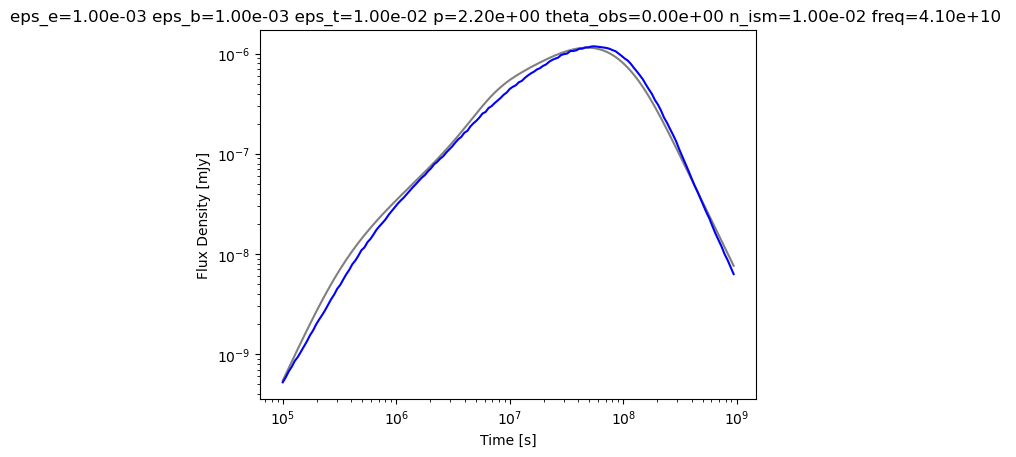

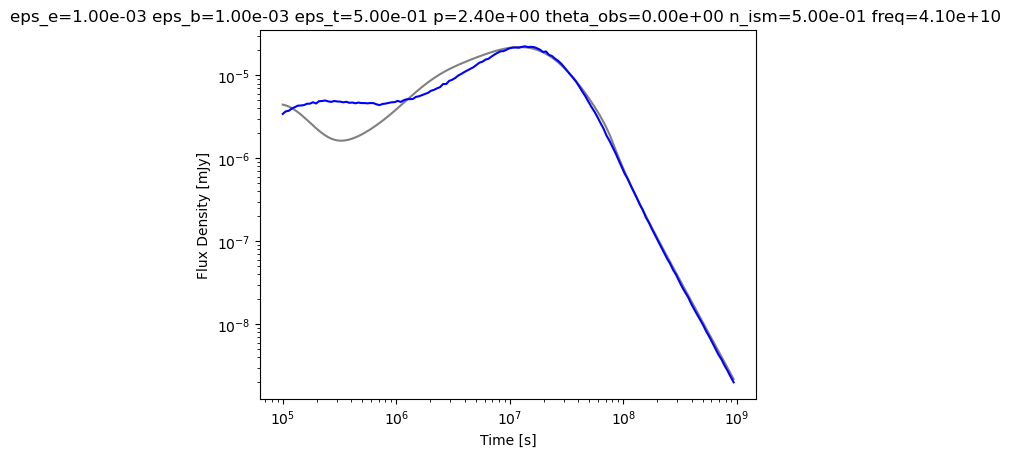

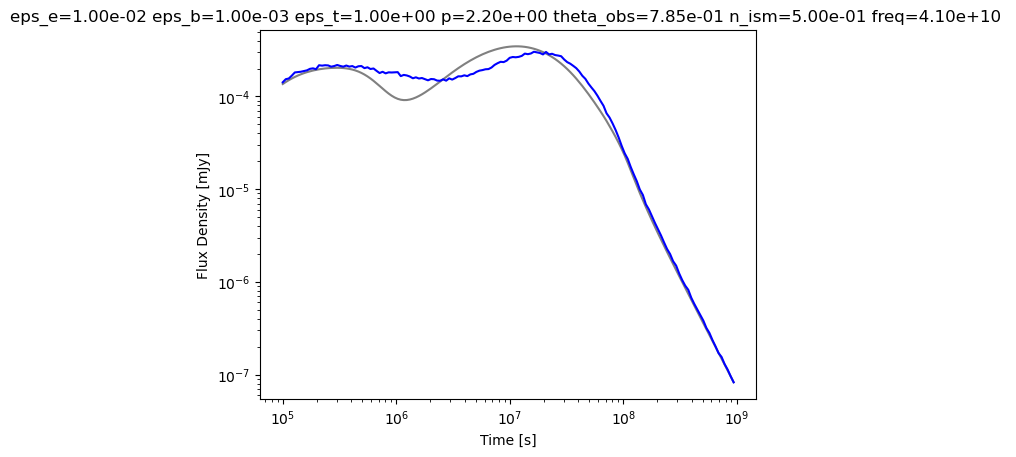

In [142]:

def plot_one(i = 0):
    
    lc = lcs[i]
    par = pars[i]
    title = "".join([_par+"="+f"{_val:.2e} " for _par,_val in zip(features_names,par)])
    plt.loglog(times, lc, color='gray')

    lc_nn = inference(par, model, dataset, device)
    lc_nn = lc_nn[0]
    plt.ylabel("Flux Density [mJy]")
    plt.xlabel("Time [s]")
    plt.loglog(times, lc_nn, color='blue')
    plt.title(title)
    plt.show()
    
plot_one(10)
plot_one(1000)
plot_one(10000)

In [143]:
# Garbage

In [144]:
# log_pars = pars.copy()
# log_pars[:,0:4] = np.log10(pars[:,0:4])
# log_pars[:,6:8] = np.log10(pars[:,6:8])

for i in range(len(pars[0,:])):
    print(f"i={i}, min={np.min(pars[:,i])} max={np.max(pars[:,i])}")

# pars[6:8] = np.log10(pars[6:8])
scaler = preprocessing.MinMaxScaler()
scaler.fit(pars)
normalized = scaler.transform(pars)
print(f"scaler.data_max_={scaler.data_max_}")
print(f"scaler.data_min_={scaler.data_min_}")
print(f"scaler.data_range_={scaler.data_range_}")
print(normalized.shape)
print(pars[-1])
print(normalized[-1])

i=0, min=0.001 max=0.5
i=1, min=0.001 max=0.5
i=2, min=0.01 max=1.0
i=3, min=2.2 max=2.8
i=4, min=0.0 max=1.5707963267948966
i=5, min=0.001 max=1.0
i=6, min=2400000000.0 max=93000000000.0
scaler.data_max_=[5.00000000e-01 5.00000000e-01 1.00000000e+00 2.80000000e+00
 1.57079633e+00 1.00000000e+00 9.30000000e+10]
scaler.data_min_=[1.0e-03 1.0e-03 1.0e-02 2.2e+00 0.0e+00 1.0e-03 2.4e+09]
scaler.data_range_=[4.99000000e-01 4.99000000e-01 9.90000000e-01 6.00000000e-01
 1.57079633e+00 9.99000000e-01 9.06000000e+10]
(43200, 7)
[5.00000000e-01 5.00000000e-01 1.00000000e+00 2.80000000e+00
 1.57079633e+00 1.00000000e+00 9.30000000e+10]
[1. 1. 1. 1. 1. 1. 1.]


In [ ]:
# Evaluate model
def evaluate_model(model:CVAE, dataset:LightCurveDataset, device):
    pass